# House sales predictions

## Introduction

## Table of content
1. [Cleaning the data](#first-bullet)
2. [Data Exploration](#second-bullet)

    2.1 [Lets plot some features](#first-bullet)

## Data

## Imports

In [345]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import lightgbm as lgb
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso , BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

pd.set_option('display.max_columns', None)
base = "./challenge_data/"

## Reading the data

In [346]:
# loading the data
houseDataDF = pd.read_csv(base + "train.csv")
idColl = houseDataDF.Id
houseDataDF = houseDataDF.drop(["Id"],axis=1)
houseDataDF.index = idColl
trainSetLength = len(houseDataDF.values)

testDF = pd.read_csv(base + "test.csv")
idColl = testDF.Id
testDF = testDF.drop(["Id"],axis=1)
testDF.index = idColl
print(testDF.shape)

(260, 79)


# Data Exploration

Text(0.5,1,'Percent missing data by feature (training data)')

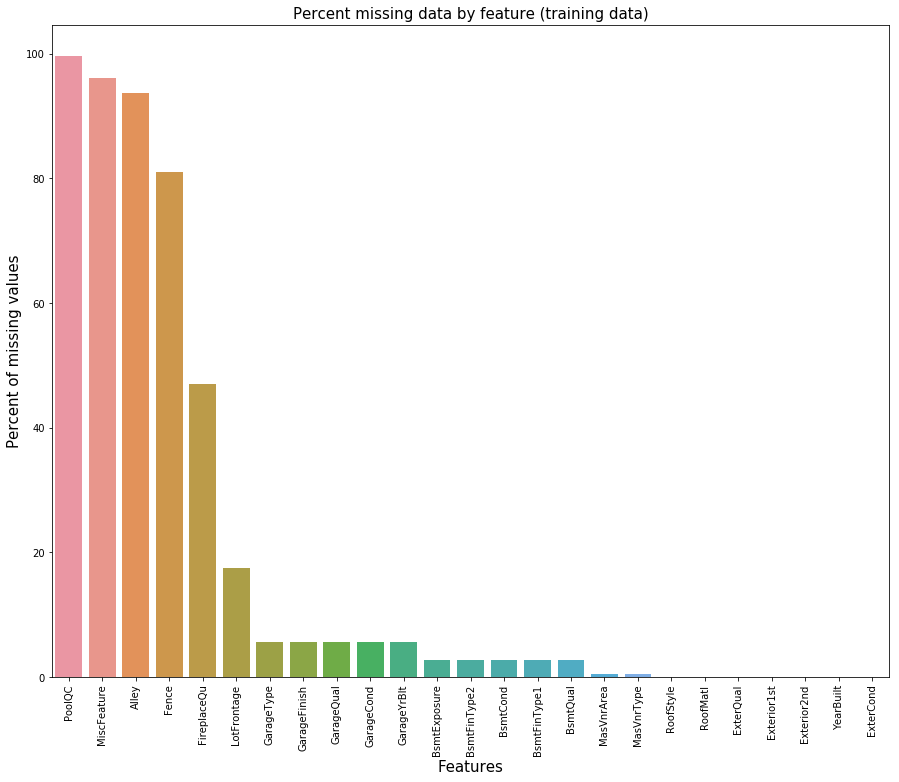

In [347]:
nulls = pd.DataFrame(houseDataDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(houseDataDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (training data)', fontsize=15)

Text(0.5,1,'Percent missing data by feature (test data)')

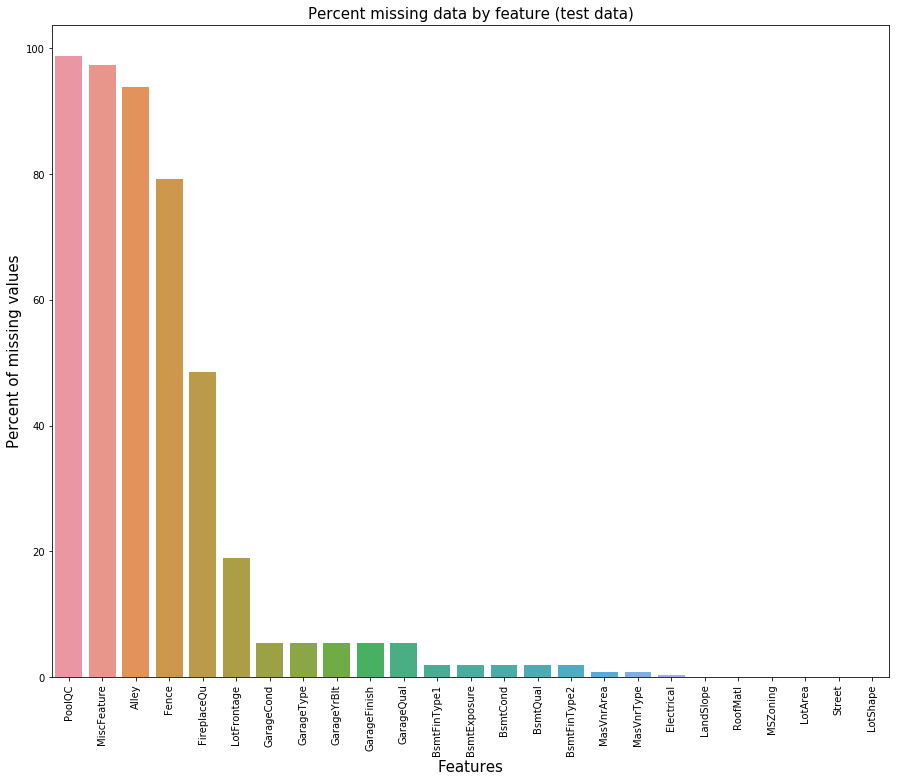

In [348]:
nulls = pd.DataFrame(testDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(testDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (test data)', fontsize=15)

In [349]:
categoricals = houseDataDF.select_dtypes(include=[np.number])
categoricals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1133.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,45.260000,564.553333,1054.700000,1157.430833,344.993333,6.553333,1508.97750,0.421667,0.061667,1.560833,0.382500,2.857500,1.045000,6.494167,0.614167,1978.368932,1.763333,472.604167,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,158.931453,440.388327,419.996306,375.238607,437.038023,52.077992,517.38033,0.520342,0.247484,0.552165,0.499735,0.819199,0.219123,1.614664,0.642113,24.812865,0.743494,212.722444,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,225.000000,796.000000,882.000000,0.000000,0.000000,1125.75000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,0.000000,472.000000,1002.500000,1087.000000,0.000000,0.000000,1456.00000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,478.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,0.000000,799.500000,1298.250000,1390.250000,728.000000,0.000000,1764.50000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,2336.000000,3206.000000,3228.000000,2065.000000,572.000000,4676.00000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1390.000000,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


In [350]:
categoricals = houseDataDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1200,1200,75,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1194,1200,1200,1200,1168,1168,1167,1168,1167,1200,1200,1200,1200,1200,1200,636,1133,1133,1133,1133,1200,4,227,47,1200,1200
unique,5,2,2,4,4,2,5,3,25,9,7,5,8,5,6,14,15,4,4,5,6,4,4,4,6,6,4,5,2,5,4,7,5,6,3,5,5,3,3,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,946,1194,41,754,1079,1199,862,1135,179,1035,1186,1001,601,945,1178,417,410,711,747,1050,534,526,1076,784,346,1034,1177,603,1122,1095,602,1117,309,718,500,1081,1093,1107,2,130,44,1036,979


In [351]:
categoricals = testDF.select_dtypes(include=[np.number])
categoricals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,260.000000,211.000000,260.000000,260.000000,260.000000,260.000000,260.000000,258.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,246.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,56.076923,69.876777,10320.288462,6.073077,5.607692,1970.884615,1984.303846,102.403101,437.884615,52.500000,579.642308,1070.026923,1186.607692,356.219231,2.573077,1545.400000,0.442308,0.038462,1.584615,0.384615,2.907692,1.053846,6.626923,0.607692,1979.138211,1.784615,474.715385,90.126923,49.630769,20.919231,2.284615,15.430769,6.680769,57.500000,6.369231,2007.838462
std,40.563048,26.911212,6255.537115,1.383314,1.079798,30.962085,21.213658,169.505783,524.993497,172.108108,449.278872,517.092050,435.144036,434.888547,27.379755,561.432388,0.512902,0.192679,0.545740,0.518159,0.800059,0.226149,1.672872,0.657551,24.154038,0.765921,219.140520,131.361754,68.915161,59.399547,26.005564,60.224091,63.147817,556.196665,2.845137,1.371547
min,20.000000,21.000000,1533.000000,3.000000,3.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,483.000000,0.000000,0.000000,630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1914.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.500000,7500.000000,5.000000,5.000000,1950.000000,1966.000000,0.000000,0.000000,0.000000,216.000000,790.250000,884.000000,0.000000,0.000000,1143.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,6.000000,0.000000,1962.250000,1.000000,332.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.750000,2007.000000
50%,50.000000,67.000000,9600.000000,6.000000,5.000000,1971.500000,1992.000000,0.000000,360.000000,0.000000,514.000000,946.000000,1086.000000,0.000000,0.000000,1510.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,484.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11515.500000,7.000000,6.000000,2001.250000,2004.000000,160.000000,704.750000,0.000000,841.750000,1289.500000,1407.750000,739.500000,0.000000,1844.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,8.000000,1.000000,2003.000000,2.000000,573.000000,168.000000,70.500000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,63887.000000,10.000000,9.000000,2009.000000,2009.000000,796.000000,5644.000000,1031.000000,2002.000000,6110.000000,4692.000000,1611.000000,384.000000,5642.000000,2.000000,1.000000,3.000000,2.000000,6.000000,2.000000,12.000000,3.000000,2009.000000,4.000000,1418.000000,736.000000,547.000000,301.000000,304.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000


In [352]:
categoricals = testDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,260,260,16,260,260,260,260,260,260,260,260,260,260,260,260,260,260,258,260,260,260,255,255,255,255,255,260,260,260,259,260,260,134,246,246,246,246,260,3,54,7,260,260
unique,5,1,2,4,4,1,5,3,24,8,2,5,8,6,5,11,12,4,4,3,6,4,3,4,6,6,6,4,2,3,4,5,5,5,3,3,4,3,2,4,3,5,5
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,205,260,9,171,232,260,190,247,46,225,259,219,125,196,256,98,94,153,159,232,113,123,235,169,86,222,251,138,243,239,133,243,71,152,105,230,233,233,2,27,5,231,219


## Finding feature relations

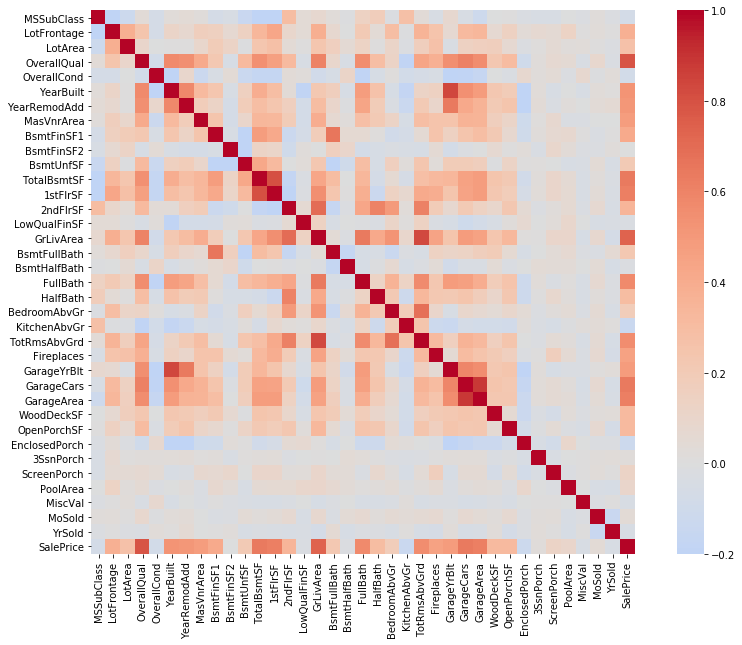

In [353]:
plt.figure(figsize=(15,10))
corr = houseDataDF.corr()


sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-0.2, square=True, center=0,cmap='coolwarm'
           )

In [354]:

corrAsList = list(zip(corr.tail(1).values[0],list(corr)))

sortedCorr = sorted(corrAsList,key=lambda x : x[0],reverse=True)

corrDF = pd.DataFrame(data=np.array(sortedCorr),columns=["Correlation","Feature"])
print(corrDF)

highestCorrFeatures = corrDF["Feature"].values[1:11]
print(highestCorrFeatures)

              Correlation        Feature
0                     1.0      SalePrice
1      0.7891424854776941    OverallQual
2      0.7403792470454845      GrLivArea
3      0.6419166279661711    TotalBsmtSF
4        0.64096125033065     GarageCars
5      0.6233291704658925     GarageArea
6      0.6185556125238022       1stFlrSF
7      0.5718673954241766       FullBath
8      0.5594350061389467   TotRmsAbvGrd
9      0.5231935965259926      YearBuilt
10     0.5099162267843296   YearRemodAdd
11     0.4897937323734207    GarageYrBlt
12     0.4814062739648941     MasVnrArea
13    0.45852829861731603     Fireplaces
14    0.40756765753188795     BsmtFinSF1
15    0.37838726355061547    LotFrontage
16    0.34862304737574773       2ndFlrSF
17      0.315547922752467    OpenPorchSF
18    0.31537873326268706     WoodDeckSF
19      0.299779290210096       HalfBath
20     0.2668111298076052        LotArea
21     0.2212091220474469   BsmtFullBath
22    0.20604955171845812      BsmtUnfSF
23    0.18382869

## Lets plot some features

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

/home/marius/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count      1200.000000
mean     181414.628333
std       81070.908544
min       34900.000000
25%      129900.000000
50%      163700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

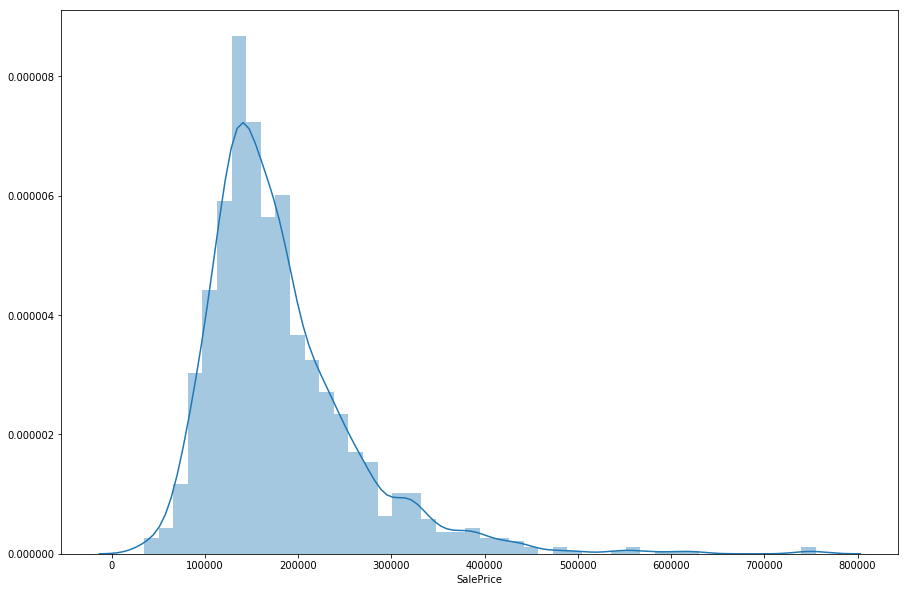

In [355]:
plt.figure(figsize=(15,10))
sns.distplot(houseDataDF.SalePrice)
houseDataDF.SalePrice.describe()

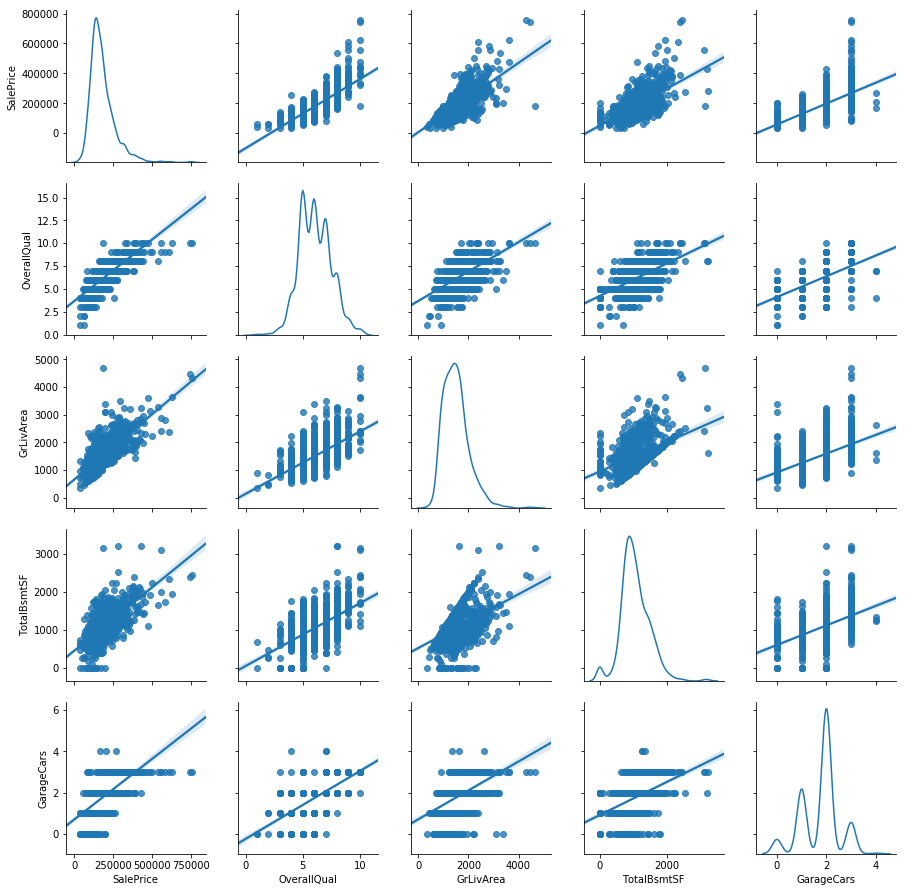

In [356]:
sns.pairplot(houseDataDF[corrDF["Feature"].values[:5]],kind="reg",diag_kind="kde")

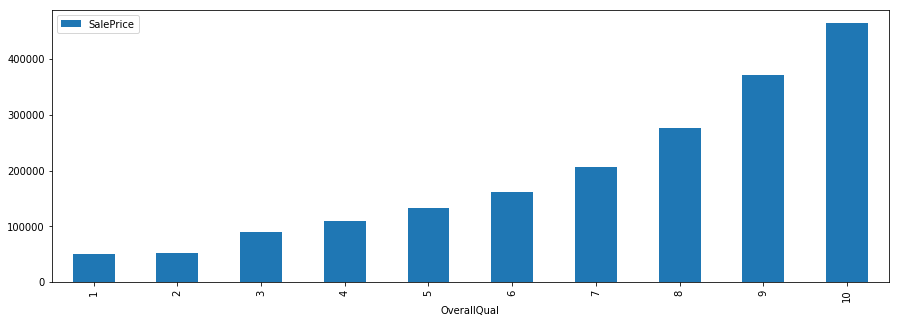

In [357]:
priceQualityDF = houseDataDF[["SalePrice","OverallQual"]]

avgPriceQualityDF = priceQualityDF.groupby(["OverallQual"]).mean()

avgPriceQualityDF.plot.bar(figsize=(15,5))

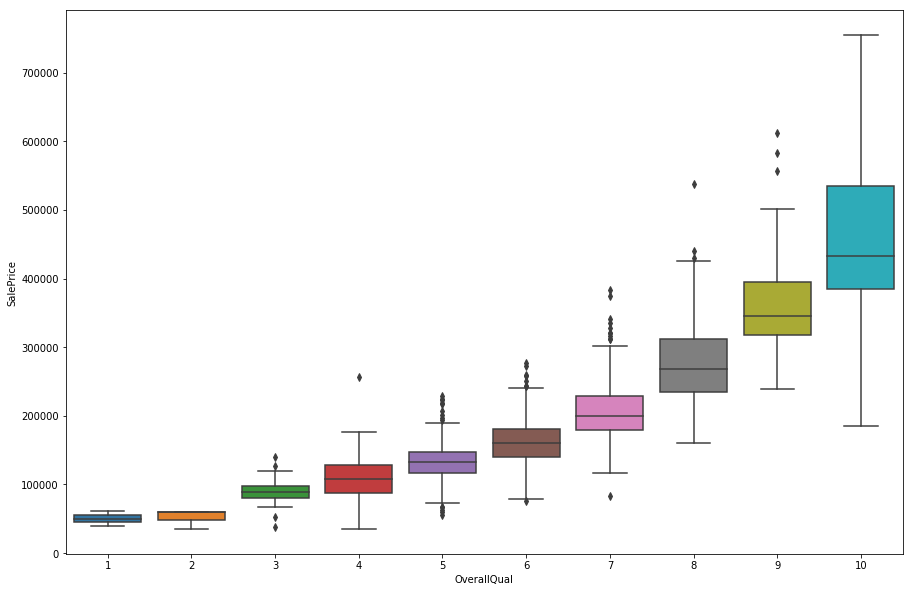

In [358]:
plt.figure(figsize=(15,10))
sns.boxplot(x='OverallQual',
               y='SalePrice', 
               data=houseDataDF)


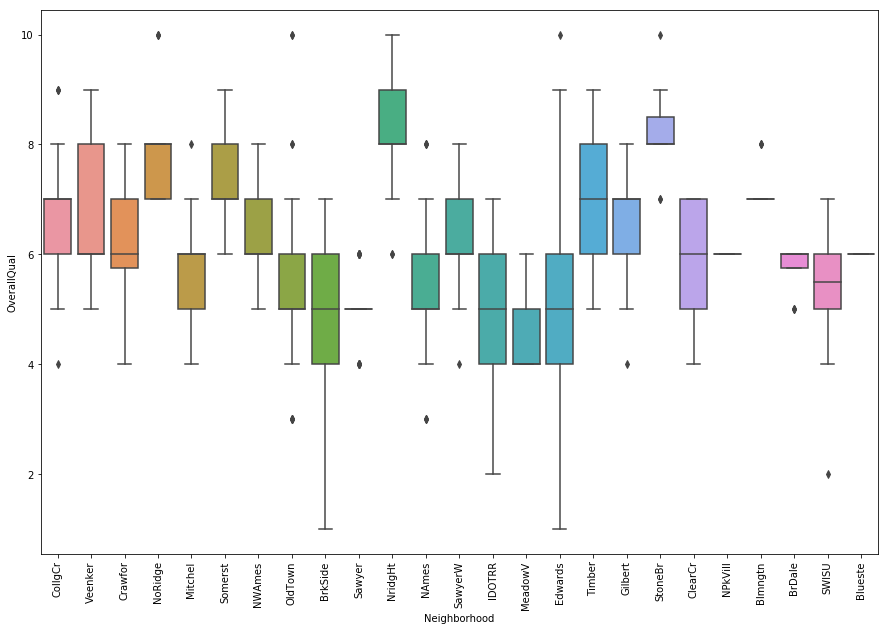

In [359]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.boxplot(x='Neighborhood',
               y='OverallQual', 
               data=houseDataDF)

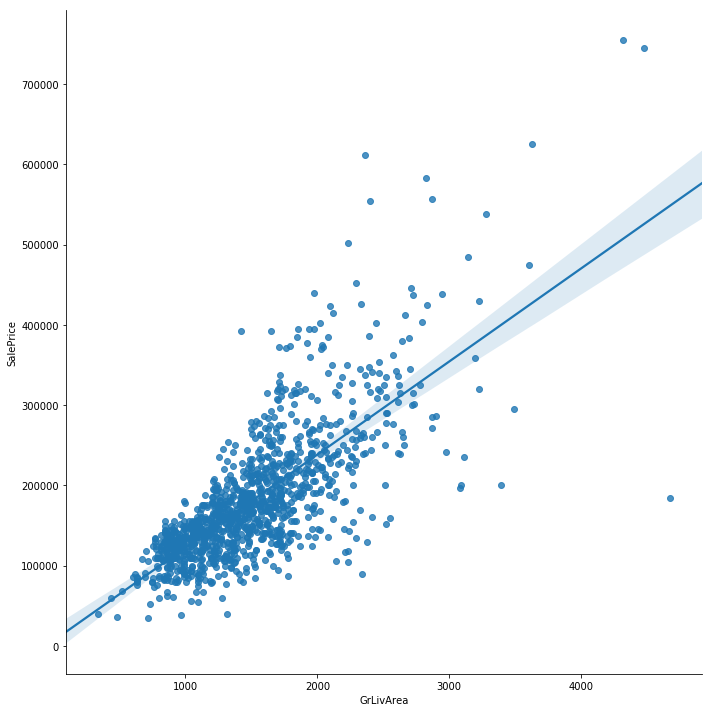

In [360]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=True,size=10) 

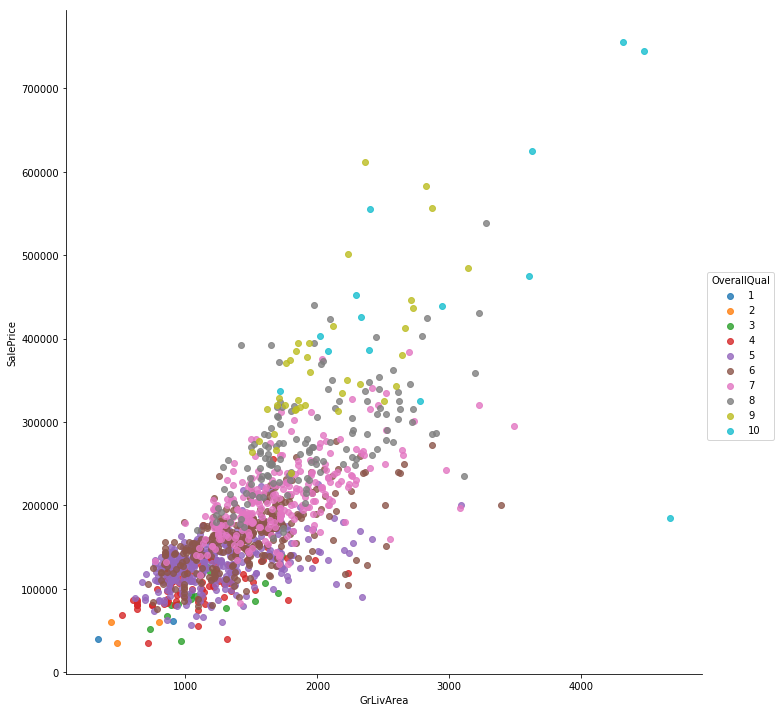

In [361]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallQual") 

In [362]:
res = houseDataDF.query('SalePrice <= 200000 & OverallQual == 10 ')[highestCorrFeatures]
outliers = res.index.values
res

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
524,10,4676,3138,3,884,3138,3,11,2007,2008


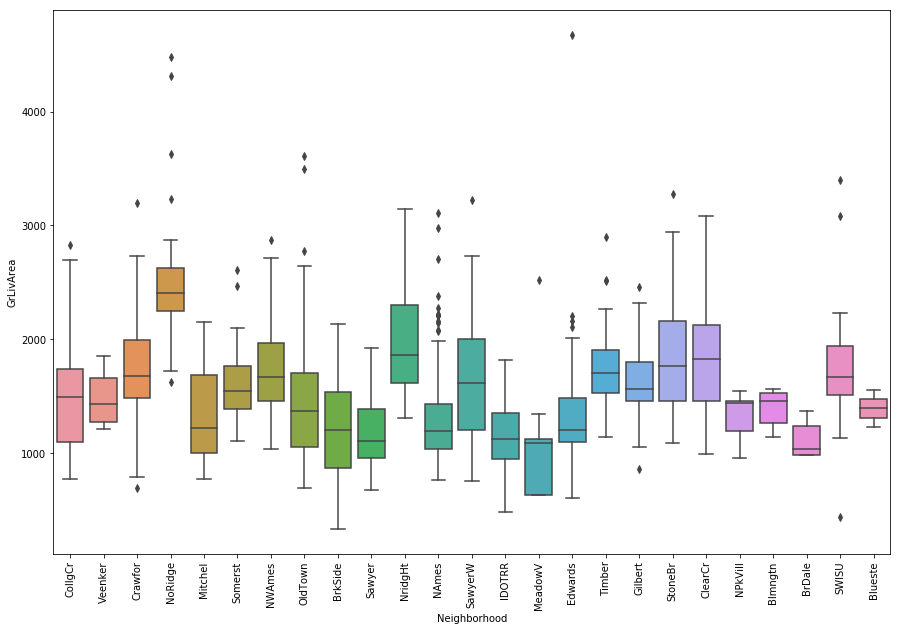

In [363]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.boxplot(x='Neighborhood',
               y='GrLivArea', 
               data=houseDataDF)

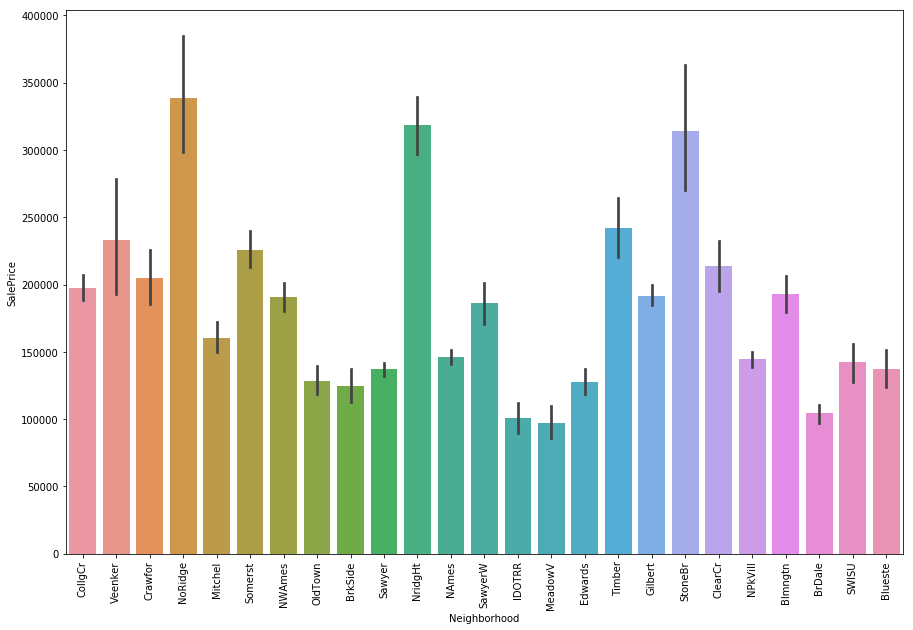

In [364]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Neighborhood", y="SalePrice", data=houseDataDF)

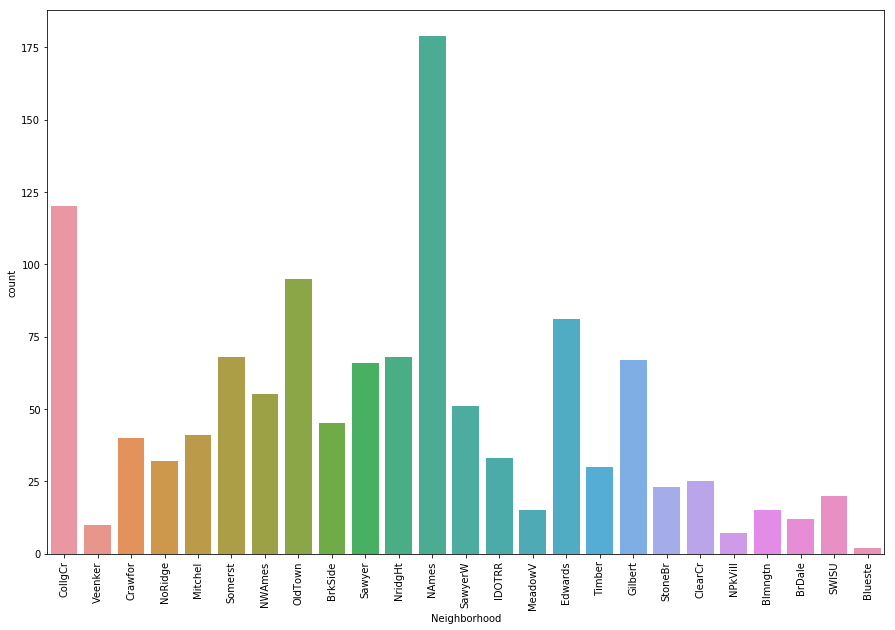

In [365]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.countplot(x="Neighborhood", data=houseDataDF)

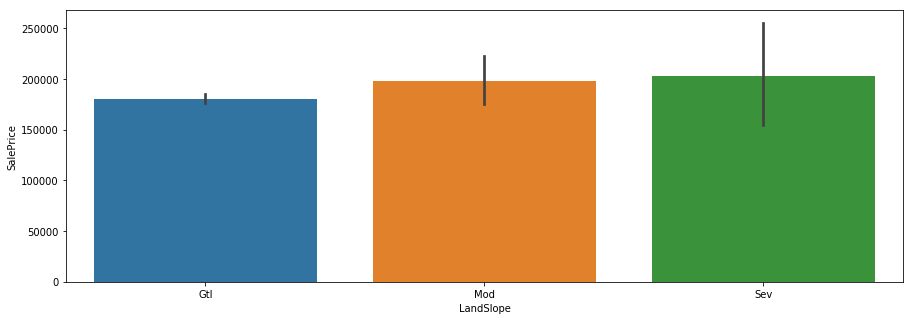

In [366]:
plt.figure(figsize=(15,5))
sns.barplot(x="LandSlope", y="SalePrice", data=houseDataDF)

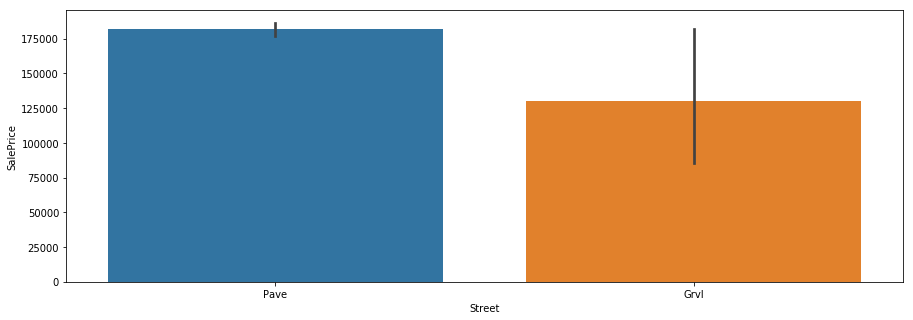

In [367]:
plt.figure(figsize=(15,5))
sns.barplot(x="Street", y="SalePrice", data=houseDataDF)

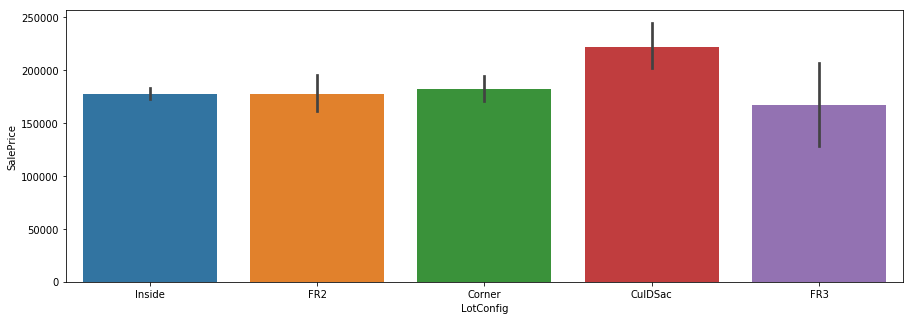

In [368]:
plt.figure(figsize=(15,5))
sns.barplot(x="LotConfig", y="SalePrice", data=houseDataDF)

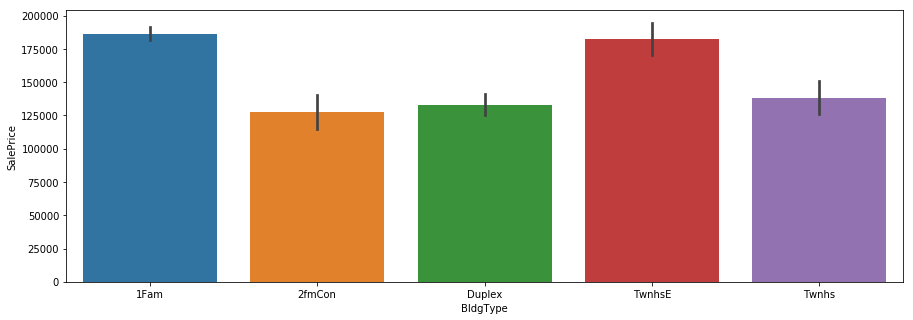

In [369]:
plt.figure(figsize=(15,5))
sns.barplot(x="BldgType", y="SalePrice", data=houseDataDF)

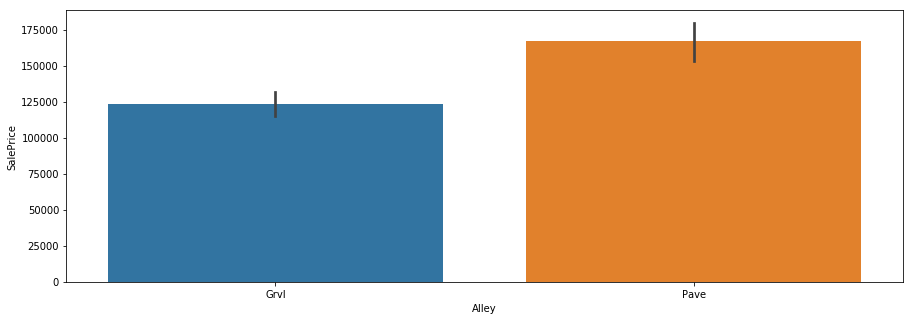

In [370]:
plt.figure(figsize=(15,5))
sns.barplot(x="Alley", y="SalePrice", data=houseDataDF)

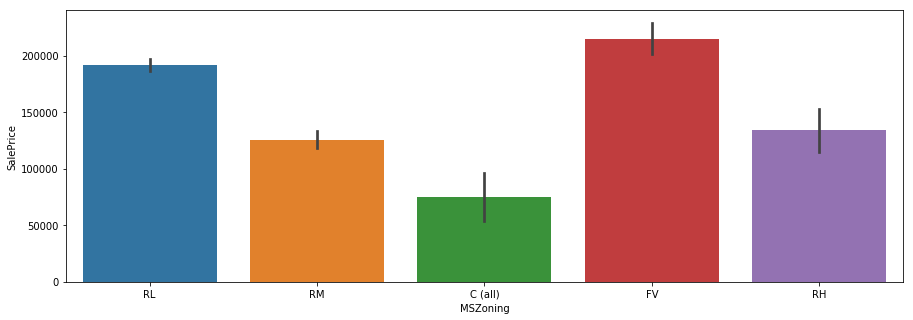

In [371]:
plt.figure(figsize=(15,5))
sns.barplot(x="MSZoning", y="SalePrice", data=houseDataDF)

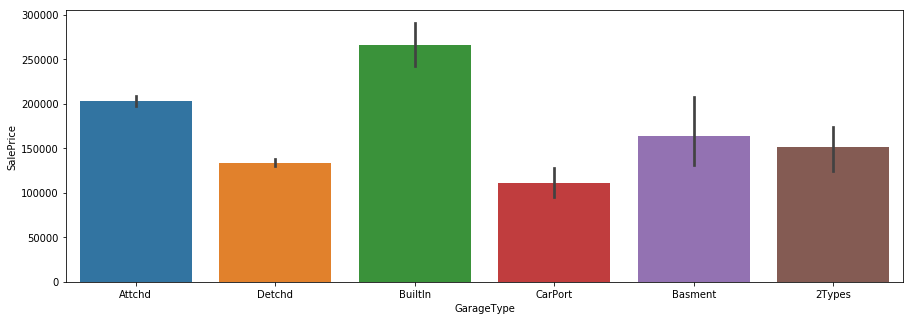

In [372]:
plt.figure(figsize=(15,5))
sns.barplot(x="GarageType", y="SalePrice", data=houseDataDF)

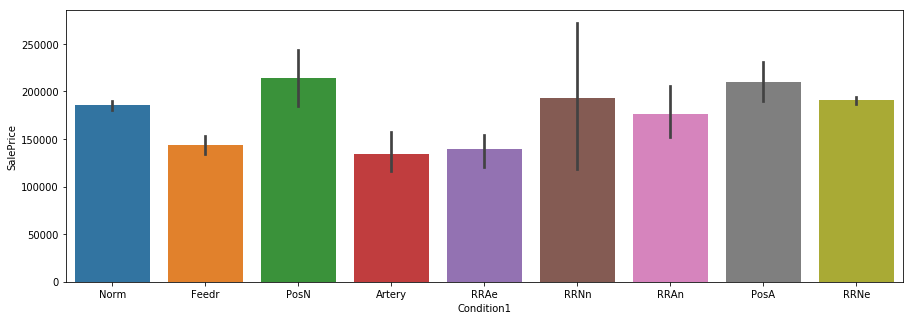

In [373]:
plt.figure(figsize=(15,5))
sns.barplot(x="Condition1", y="SalePrice", data=houseDataDF)

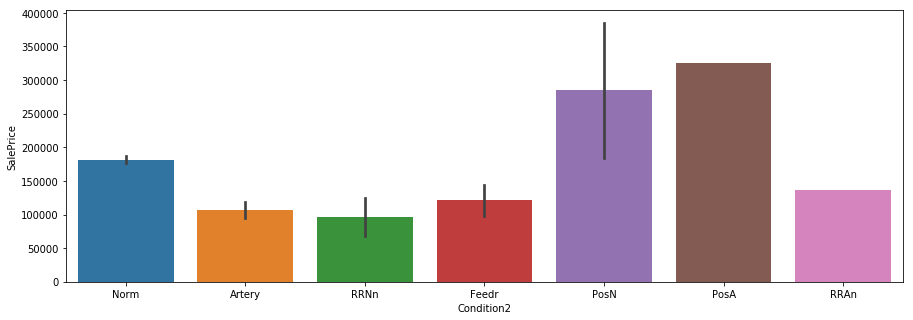

In [374]:
plt.figure(figsize=(15,5))
sns.barplot(x="Condition2", y="SalePrice", data=houseDataDF)

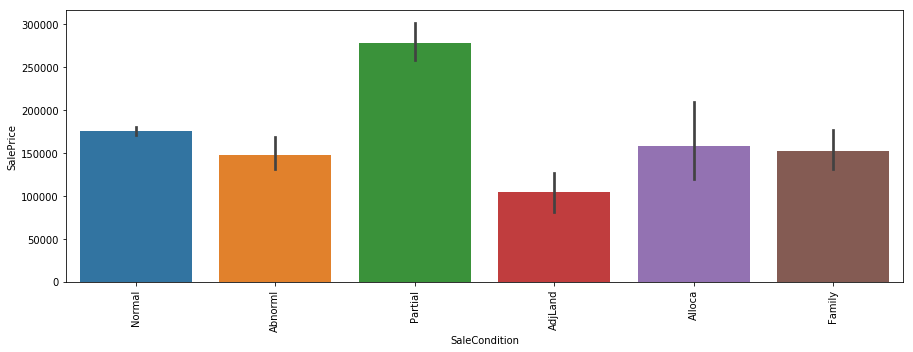

In [375]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='90')
sns.barplot(x="SaleCondition", y="SalePrice", data=houseDataDF)

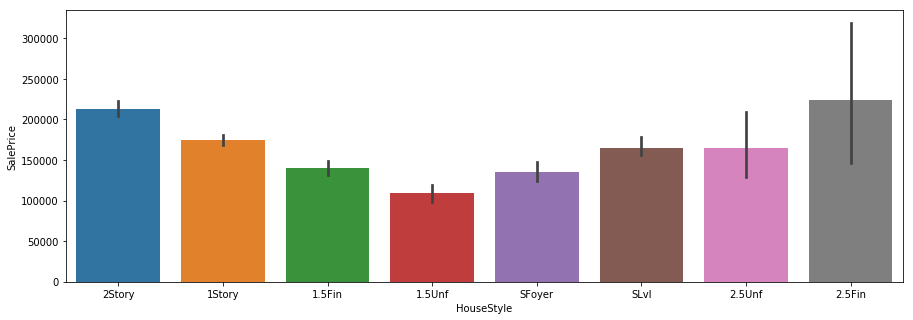

In [376]:
plt.figure(figsize=(15,5))
sns.barplot(x="HouseStyle", y="SalePrice", data=houseDataDF)

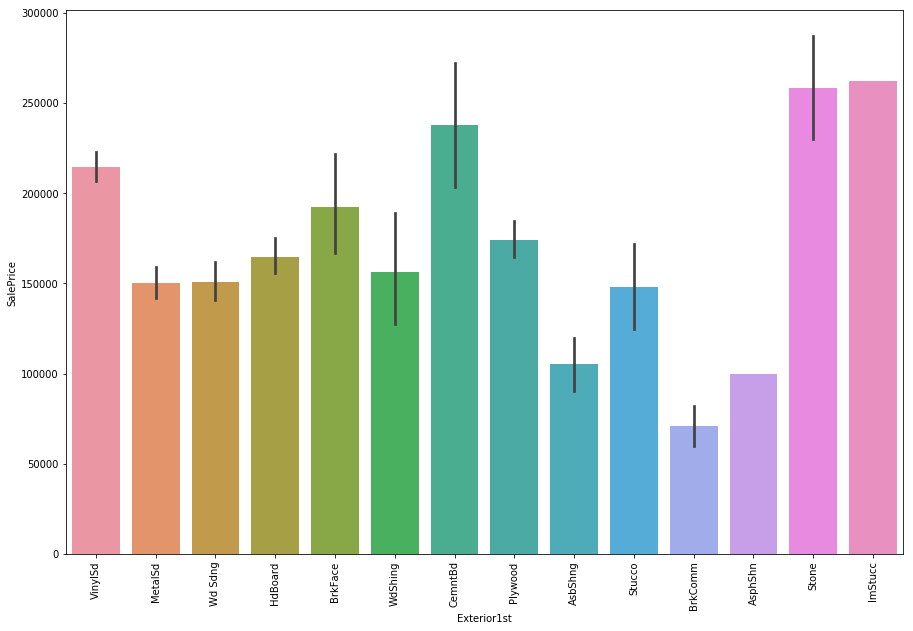

In [377]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Exterior1st", y="SalePrice", data=houseDataDF)

# Cleaning the data

## Removing outliers

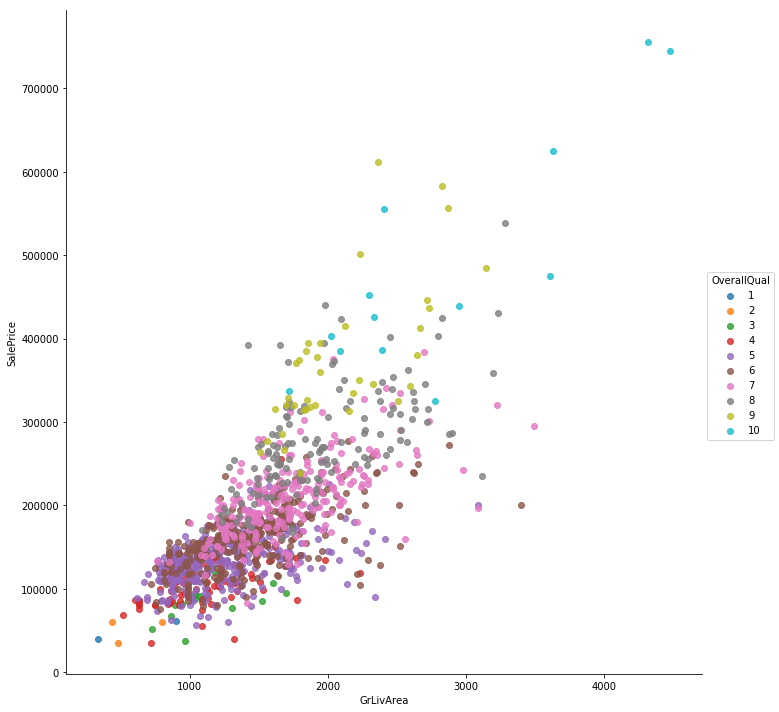

In [378]:
houseDataCleanedDF = houseDataDF.drop(outliers)
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataCleanedDF,fit_reg=False,size=10,hue="OverallQual")

## Feature engineering

In [379]:
y = np.log(houseDataCleanedDF.SalePrice)
houseDataCleanedDF = houseDataCleanedDF.drop(["SalePrice"],axis=1)
houseDataCleanedDF = pd.concat([houseDataCleanedDF,testDF])

In [380]:
def makeFeatures(houseDataDF):


    houseDataDF['EncodedStreet'] = pd.get_dummies(houseDataDF.Street, drop_first=True)
 
    houseDataDF['EncodedAlley'] = pd.get_dummies(houseDataDF.Alley, drop_first=True)

        
    num_neigbourhoods = len(pd.get_dummies(houseDataDF.Neighborhood, drop_first=True).columns)
    houseDataDF[["N"+str(i) for i in range(num_neigbourhoods)]] = pd.get_dummies(houseDataDF.Neighborhood, drop_first=True)
    
    num_styles = len(pd.get_dummies(houseDataDF.HouseStyle, drop_first=True).columns)
    houseDataDF[["HS"+str(i) for i in range(num_styles)]] = pd.get_dummies(houseDataDF.HouseStyle, drop_first=True)
    
    num_saleconditions = len(pd.get_dummies(houseDataDF.SaleCondition, drop_first=True).columns)
    houseDataDF[["SC"+str(i) for i in range(num_saleconditions)]] = pd.get_dummies(houseDataDF.SaleCondition, drop_first=True)
    
    num_config = len(pd.get_dummies(houseDataDF.LotConfig, drop_first=True).columns)
    houseDataDF[["LC"+str(i) for i in range(num_config)]] = pd.get_dummies(houseDataDF.LotConfig, drop_first=True)
    
    num_buildings = len(pd.get_dummies(houseDataDF.BldgType, drop_first=True).columns)
    houseDataDF[["BZ"+str(i) for i in range(num_buildings)]] = pd.get_dummies(houseDataDF.BldgType, drop_first=True)
    
    num_zones = len(pd.get_dummies(houseDataDF.MSZoning, drop_first=True).columns)
    houseDataDF[["Z"+str(i) for i in range(num_zones)]] = pd.get_dummies(houseDataDF.MSZoning, drop_first=True)
    

    num_garages = len(pd.get_dummies(houseDataDF.GarageType, drop_first=True).columns)
    houseDataDF[["GT"+str(i) for i in range(num_garages)]] = pd.get_dummies(houseDataDF.GarageType, drop_first=True)
    
    num_conditions1 = len(pd.get_dummies(houseDataDF.Condition1, drop_first=True).columns)
    houseDataDF[["SC"+str(i) for i in range(num_conditions1)]] = pd.get_dummies(houseDataDF.Condition1, drop_first=True)
    
    houseDataDF['EncodedSurroundings'] = [1 if x=='PosN' or x=='PosA' or y=='PosN' or y=='PosA' else 0\
        for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]

    houseDataDF['EncodedSound'] = [1 if x=='Feedr' or x=='Artery' or x=='RRAe' or y=='Feedr'\
        or y=='Artery' or y=='RRAe' else 0 for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]
    
    # Add feature for total house area.
    houseDataDF['TotalSF'] = houseDataDF['TotalBsmtSF'] + houseDataDF['1stFlrSF'] + houseDataDF['2ndFlrSF']
    
    #houseDataDF['Remodeled'] =  [1 if x != y else 0 for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    houseDataDF['TimeBetweenRemodAndBuild'] =  [x-y for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['RemodeledResent'] =  [1 if x != y and 2010 - x < 10 else 0 for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['Age'] =  [2010 - x for x in houseDataDF["YearBuilt"]]
    
    houseDataDF['AvgQual'] =  [(int(x)+int(y))/2 for x,y in zip(houseDataDF["OverallQual"],houseDataDF["OverallCond"])]
    
    houseDataDF['TotalPorchSF'] = houseDataDF['OpenPorchSF'] + houseDataDF['EnclosedPorch'] + houseDataDF['3SsnPorch'] + houseDataDF['ScreenPorch']
    
    
    
    
    return houseDataDF


houseDataCleanedDF = makeFeatures(houseDataCleanedDF)
# TODO : Add feature for centrality

## Fixing skew

In [381]:
def fixSkew(houseDataDF):
    numeric_feats = houseDataDF.dtypes[houseDataDF.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = houseDataDF[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


    skewed_features = skewness.index

    lam = 0.15
    for feat in skewed_features:
        #all_data[feat] += 1
        if(feat not in ["SalePrice","YearBuilt"]):
            houseDataDF[feat] = boxcox1p(houseDataDF[feat], lam)
    return houseDataDF

houseDataCleanedDF = fixSkew(houseDataCleanedDF)


Skew in numerical features: 

There are 102 skewed numerical features to Box Cox transform


# Predictions

https://datascienceplus.com/linear-regression-in-python-predict-the-bay-areas-home-prices/
https://www.kaggle.com/dougdaly/house-price-modeling-with-random-forest-regressors
https://shankarmsy.github.io/stories/gbrt-sklearn.html
https://www.kaggle.com/nolberg/machine-learning-for-house-price-prediction
https://kaggle2.blob.core.windows.net/forum-message-attachments/216792/7200/MDSSKaggle_Slides_Henry.pdf
https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/jimthompson/ensemble-model-stacked-model-example
https://www.kaggle.com/janiobachmann/in-depth-analysis-house-prices-ensembling
https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook

In [382]:
data = houseDataCleanedDF.select_dtypes(include=[np.number]).interpolate().dropna()
drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1']
data = data.drop(drop_cols,axis=1)

columns = data.columns.values

currentTrainSetLenght = trainSetLength - len(outliers)
trainData = pd.DataFrame(data=data.values[:currentTrainSetLenght],columns=columns)

testData = pd.DataFrame(data=data.values[currentTrainSetLenght:],columns=columns)



In [383]:
X = trainData
training_features = X.columns.values

In [384]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

## Linear Regression

In [385]:
lr = LinearRegression()
linearModel = lr.fit(X_train,y_train)
print ("R^2 is:", linearModel.score(X_test, y_test))

R^2 is: 0.8861981158928671


In [386]:
predictions = linearModel.predict(X_test)

print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.01753263609422471


In [387]:
scores = cross_val_score(linearModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.16)


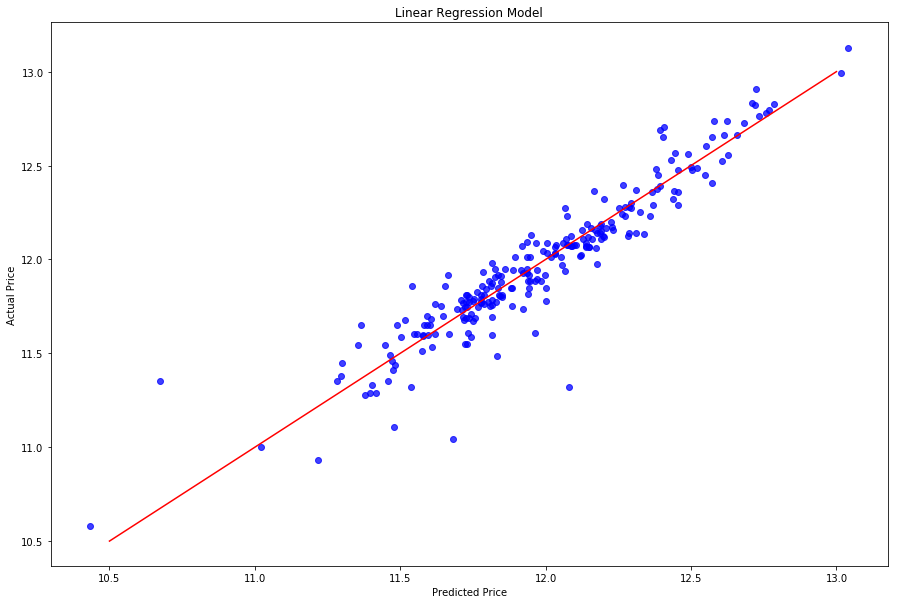

In [388]:

actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

### KernelRidge Regularization

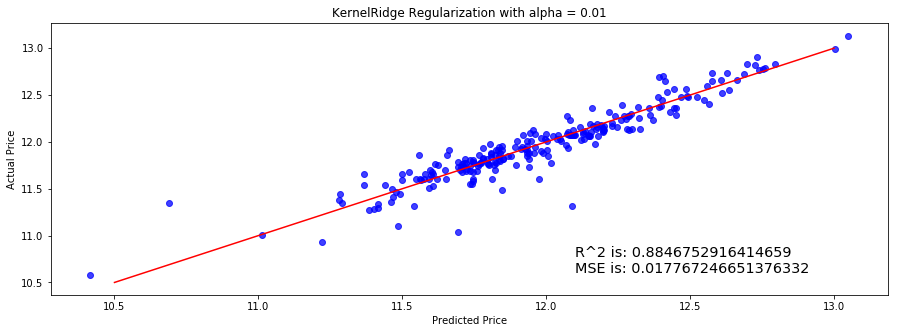

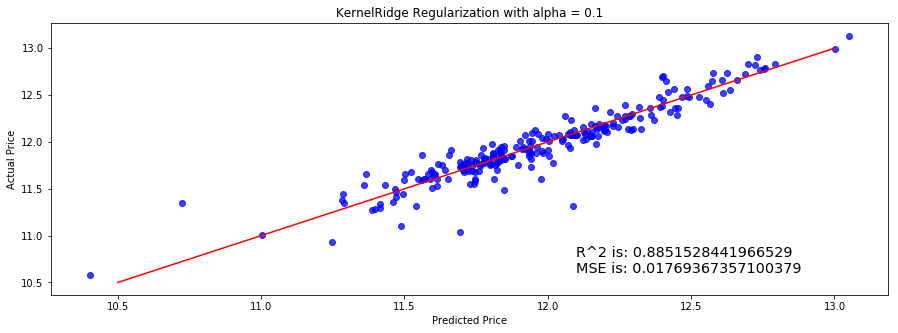

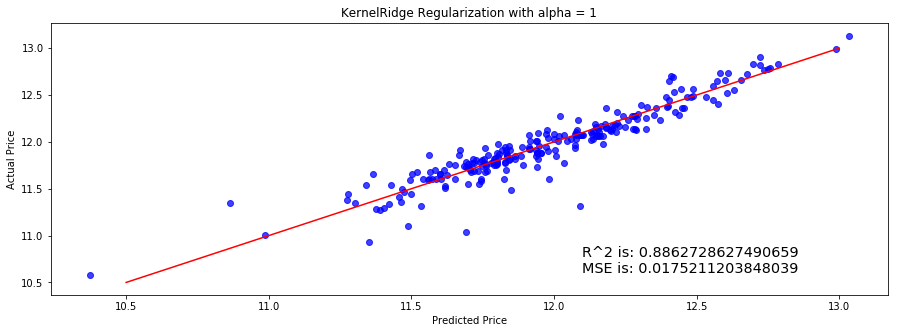

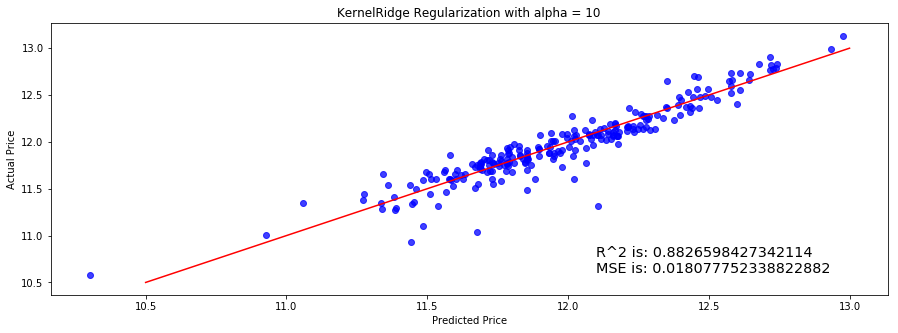

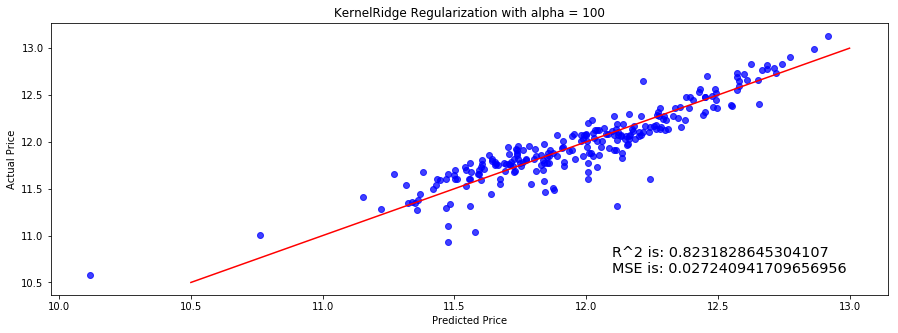

In [389]:
for alpha in [0.01,0.1,1,10,100]:
    rm = KernelRidge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    plt.figure(figsize=(15,5))
    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.plot([10.5,13],[10.5,13],"r")
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('KernelRidge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()


## BayesianRidge

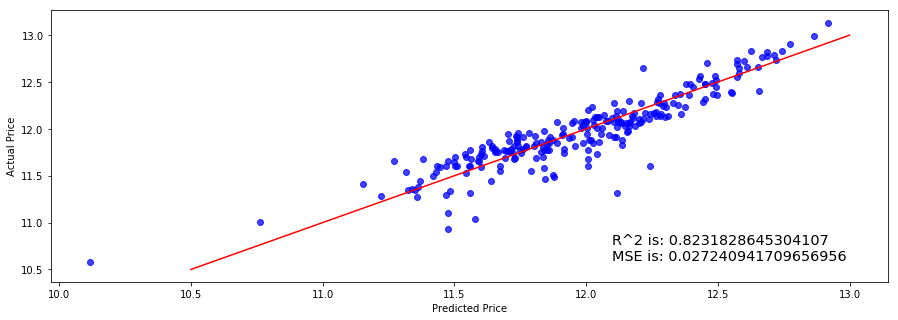

In [390]:

br = BayesianRidge(alpha_1=1e-08,alpha_2=5e-06)
bayesian_model = rm.fit(X_train, y_train)
br_preds = bayesian_model.predict(X_test)
plt.figure(figsize=(15,5))
plt.scatter(br_preds, actual_values, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

overlay = 'R^2 is: {}\nMSE is: {}'.format(
                bayesian_model.score(X_test, y_test),
                mean_squared_error(y_test, preds_ridge))
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()


## Random Forrest

In [391]:
fr = RandomForestRegressor(n_estimators=100,random_state=42)
randomForrestModel = fr.fit(X_train, y_train)
print ("R^2 is:", randomForrestModel.score(X_test, y_test))

R^2 is: 0.863123914167917


In [392]:
fr_preds = randomForrestModel.predict(X_test)
print ('MSE is:', mean_squared_error(y_test,fr_preds))

MSE is: 0.02108751205416435


In [393]:
scores = cross_val_score(randomForrestModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.19)


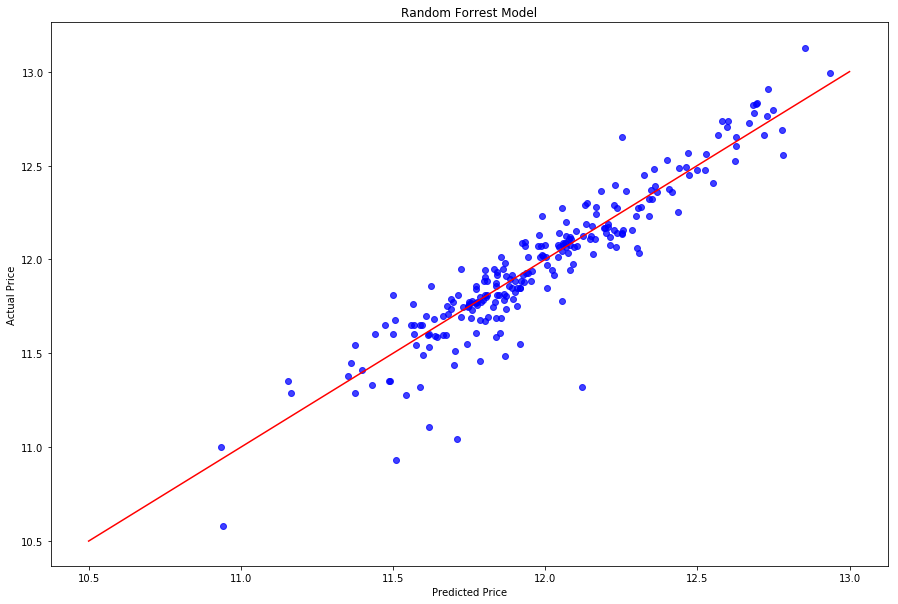

In [394]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(fr_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forrest Model')
plt.show()

## Gradient boosting

In [395]:
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)
n_jobs=4

In [396]:
def hyperparameterTuning(estimator,param_grid, n_jobs,cv): 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_)
    return cv, classifier.best_estimator_

In [397]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(15,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

R^2 is: 0.8679097755598673


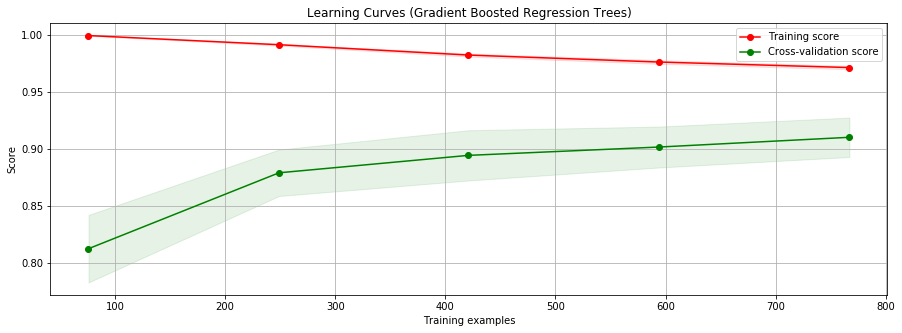

In [398]:
gb = GradientBoostingRegressor()
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(gb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
gradientBoostingModel = gb.fit(X_train, y_train)
print ("R^2 is:", gradientBoostingModel.score(X_test, y_test))

In [399]:
predictions = gradientBoostingModel.predict(X_test)
print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.02035018888204997


In [400]:
scores = cross_val_score(gradientBoostingModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.81 (+/- 0.16)


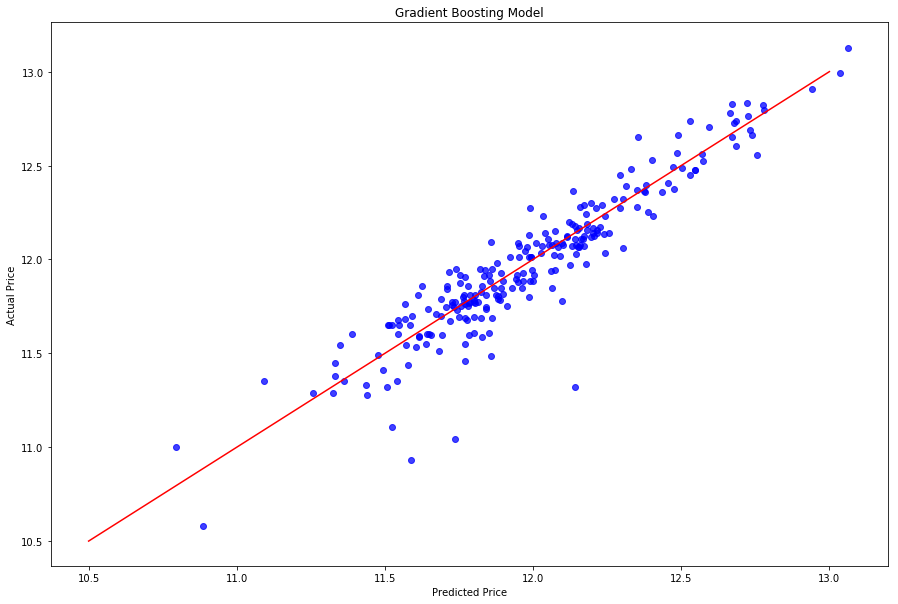

In [401]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

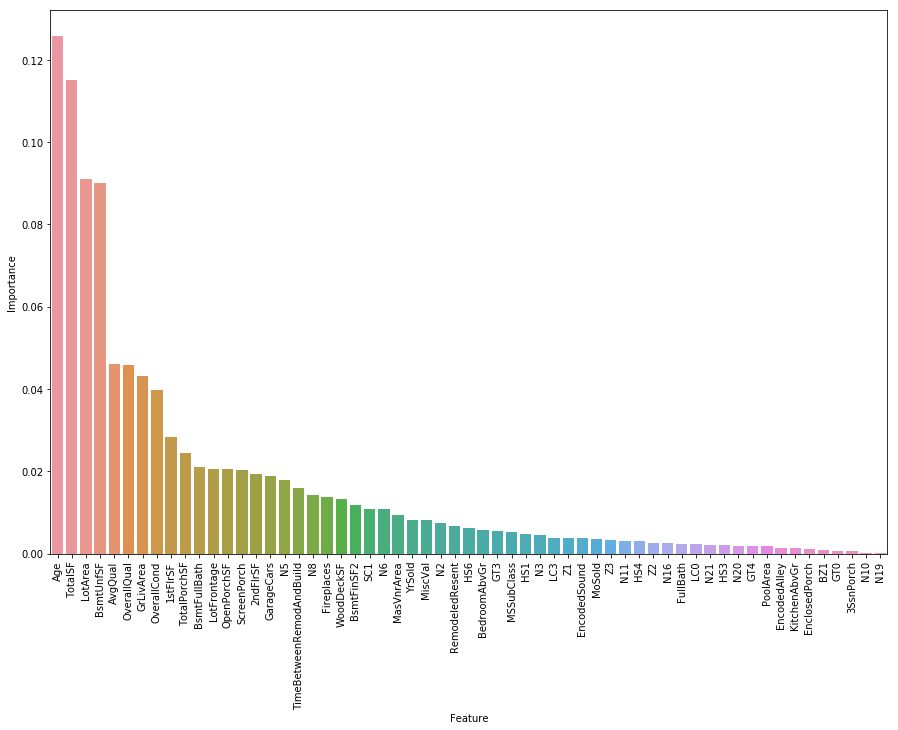

In [402]:
importances = gb.feature_importances_
columns = X_test.columns.values


feature_importance = list(zip(columns,importances))
sorted_feature_importance = np.array(sorted(feature_importance,key=lambda x : x[1],reverse=True))
sorted_feature_importance = list(map(lambda x : [x[0],float(x[1])],sorted_feature_importance))


featureImportanceDF = pd.DataFrame(data=sorted_feature_importance,columns=["Feature","Importance"]).query("Importance > 0")
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)

### Improving Gradient Boosting

In [403]:
param_grid={'n_estimators':[100],
            'learning_rate': [0.1],
            'max_depth':[6],
            'min_samples_leaf':[3],
            'max_features':[1.0],
           }

estimator = GradientBoostingRegressor()
cv,best_est = hyperparameterTuning(estimator,param_grid, n_jobs,cv)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

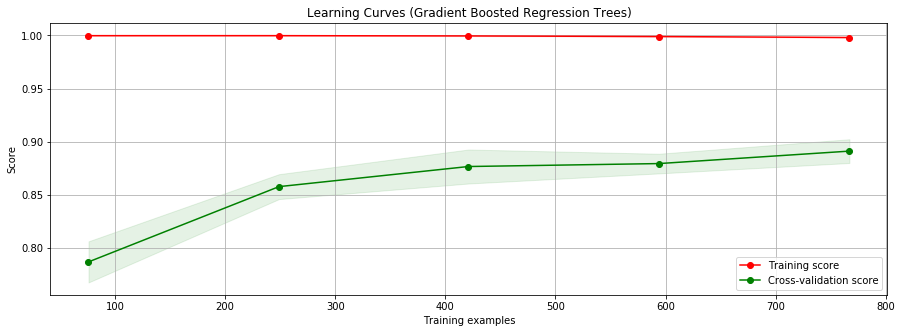

In [404]:
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features)
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [405]:
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)
print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.0195415623030897


In [406]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
n_jobs=4
#cv,best_est=GradientBooster(param_grid, n_jobs)

try:
    best_est = pickle.load( open( "GradientBoostingBestEstimator.p", "rb" ) )
    None
except:
    cv,best_est = hyperparameterTuning(param_grid, n_jobs)
    None



In [407]:
pickle.dump(best_est, open( "GradientBoostingBestEstimator.p", "wb" ) )


<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

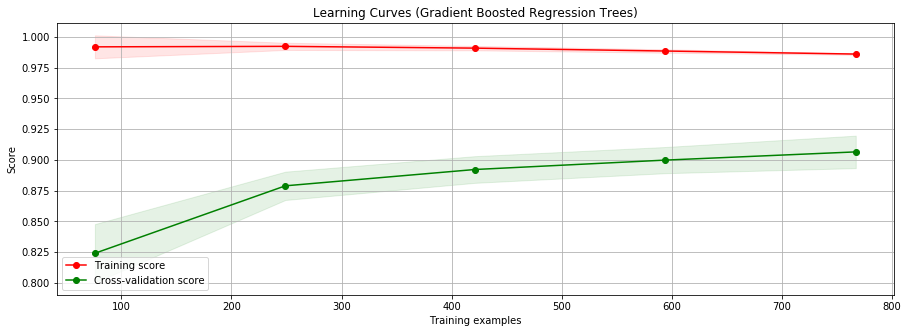

In [408]:
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features,loss="huber",random_state=5)

title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)


In [409]:
estimator.fit(X_train, y_train)
gb_preds = estimator.predict(X_test)
print ("R^2 is:", estimator.score(X_test, y_test))
print ('MSE is:', mean_squared_error(y_test, gb_preds))

R^2 is: 0.8885684128923054
MSE is: 0.01716746151866794


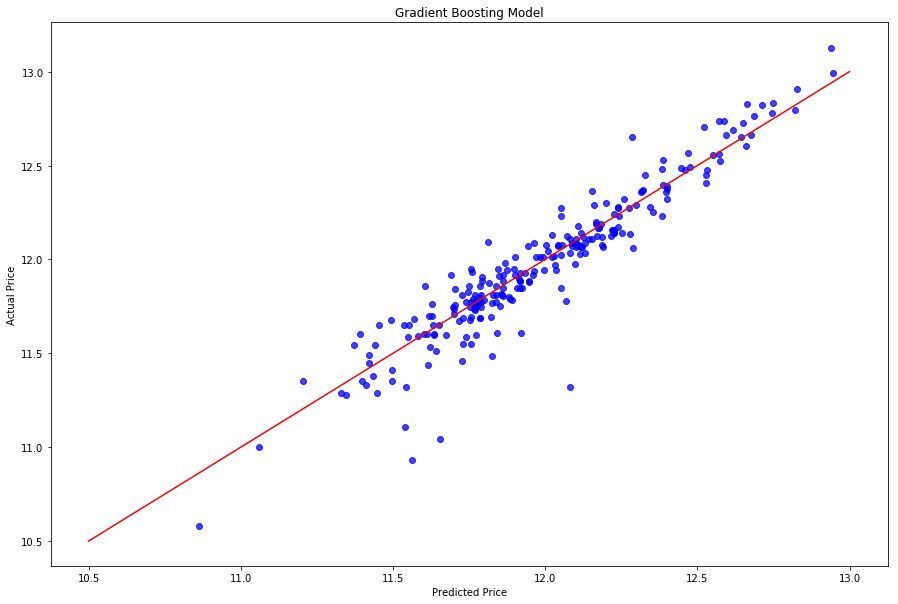

In [410]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(gb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

### Using XGBoost 

In [411]:
param_grid={'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6,8,10],
            'gamma ':[0.01,0.04,0.08,0.12,0.5], 
            'subsample':[0.5,0.75,1],
            'colsample_bytree ':[0.5,0.75,1],
            'alpha':[0.001,0.01,0.1,1],
            'n_estimators':[1000,2000,3000]
           }
try:
    best_est = pickle.load( open( "XGBoostBestEstimator.p", "rb" ) )
    
except:
    #cv,best_est = hyperparameterTuning(param_grid, n_jobs)
    None

In [412]:
#pickle.dump(best_est, open( "XGBoostBestEstimator.p", "wb" ) )

In [413]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

title = "Learning Curves (XGBoost Regression Trees)"
#plot_learning_curve(model_xgb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [414]:
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)

print ("R^2 is:", model_xgb.score(X_test, y_test))
print ('MSE is:', mean_squared_error(y_test, xgb_preds))

R^2 is: 0.8763115473695111
MSE is: 0.01905578845238284


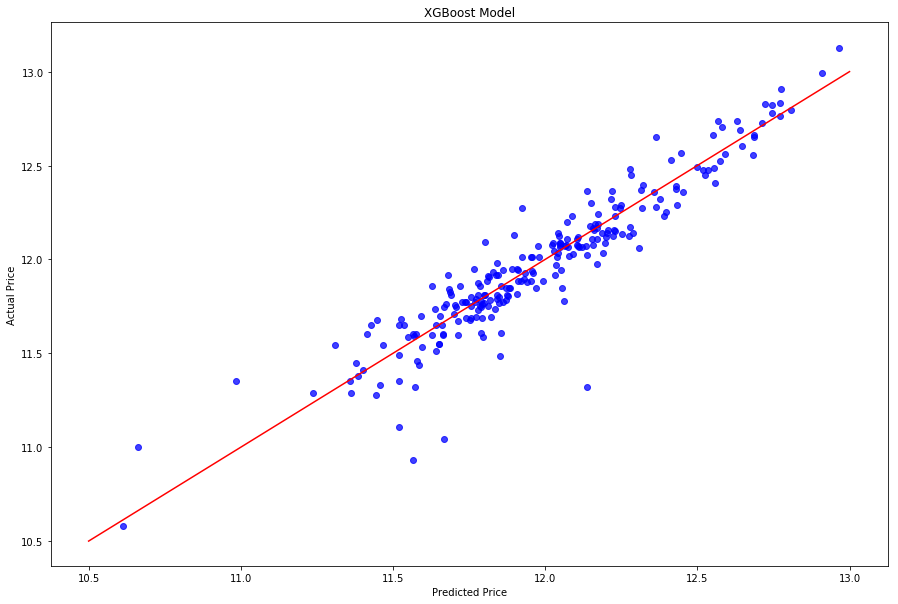

In [415]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(xgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Model')
plt.show()

### Using LightGBM

In [416]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
try:
    best_est = pickle.load( open( "LightGBMBestEstimator.p", "rb" ) )
except:
    #cv,best_est = hyperparameterTuning(param_grid, n_jobs)
    None

In [417]:
#pickle.dump(best_est, open( "LightGBMBestEstimator.p", "wb" ) )

In [418]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
title = "Learning Curves (LightGBM Regression Trees)"
#plot_learning_curve(model_lgb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [419]:
model_lgb.fit(X_train, y_train)
lgb_preds = model_lgb.predict(X_test)

print ("R^2 is:", model_lgb.score(X_test, y_test))
print ('MSE is:', mean_squared_error(y_test, lgb_preds))

R^2 is: 0.8739530540098608
MSE is: 0.0194191445262284


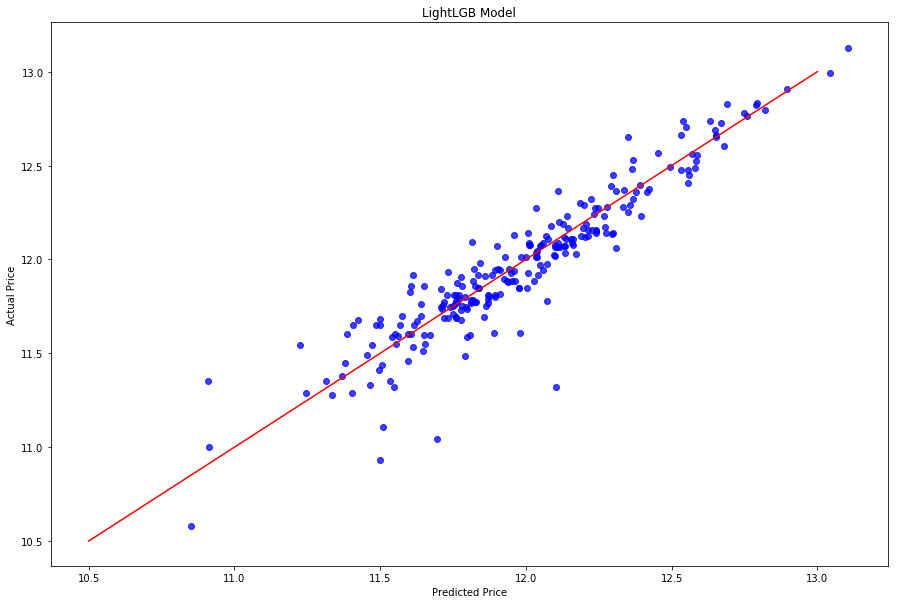

In [420]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(lgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('LightLGB Model')
plt.show()

# Using Lasso as a Meta-model

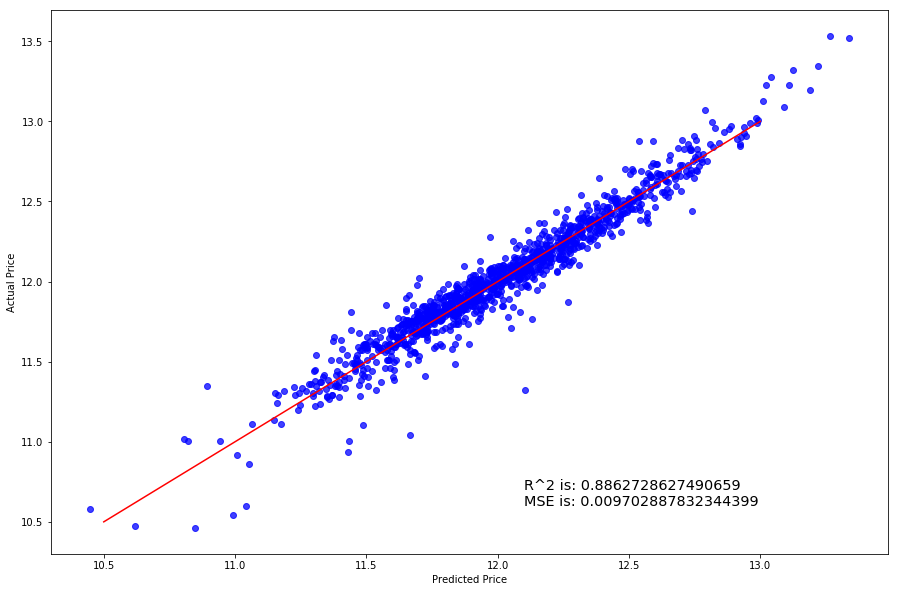

In [421]:
rm = KernelRidge(alpha=1)
ridge_model = rm.fit(X_train, y_train)
rm_preds = ridge_model.predict(X_test)

lgb_test_preds = model_lgb.predict(X)
xgb_test_preds = model_xgb.predict(X)
gb_test_preds = estimator.predict(X)
rm_test_preds = ridge_model.predict(X)

all_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T
all_test_preds = np.array([lgb_test_preds,xgb_test_preds,gb_test_preds,rm_test_preds]).T

lm = Lasso(alpha=0.001)
lasso_model = lm.fit(all_preds, y_test)
meta_preds = lasso_model.predict(all_test_preds)
plt.figure(figsize=(15,10))
plt.scatter(meta_preds, y, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
overlay = 'R^2 is: {}\nMSE is: {}'.format(
                ridge_model.score(X_test, y_test),
                mean_squared_error(y, meta_preds))
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

# Capturing large errors

In [422]:

errorDF = pd.DataFrame(data=y_test)
errorDF["Prediction"] = lgb_preds

res = errorDF.query("SalePrice < 11 & Prediction < 11.5")

outliersDF = pd.DataFrame()
outliersDF["SalePrice"] = np.exp(res.SalePrice.values)
outliersDF["Prediction"] = np.exp(res.Prediction.values)
outliersDF.index = res.index
print(outliersDF)

     SalePrice    Prediction
Id                          
534    39300.0  51533.095874


In [423]:
worstPredictions = houseDataDF.query("Id == 31 | Id == 917 | Id == 534")
columns = np.concatenate((highestCorrFeatures,["Neighborhood"]))
worstPredictions[columns]

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Neighborhood
Id,,,,,,,,,,,
31,4,1317,649,1,250,649,1,6,1920,1950,IDOTRR
534,1,334,0,0,0,334,1,2,1946,1950,BrkSide
917,2,480,480,1,308,480,0,4,1949,1950,IDOTRR


# Create submission

In [424]:
lgb_preds = model_lgb.predict(testData)
xgb_preds = model_xgb.predict(testData)
gb_preds = estimator.predict(testData)
rm_preds = ridge_model.predict(testData)

all_model_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T

final_predictions = np.exp(lasso_model.predict(all_model_preds))

submission = pd.DataFrame()
submission['Id'] = idColl
submission['SalePrice'] = final_predictions
submission.head(20)

,Id,SalePrice
0,1201,100307.529963
1,1202,197312.782639
2,1203,134530.698249
3,1204,212479.004881
4,1205,145426.336494
5,1206,282139.709786
6,1207,110931.194564
7,1208,206034.985881
8,1209,145360.551315
9,1210,287620.444534


In [425]:

ansDF = pd.read_csv(base + "train2.csv")
idColl = ansDF.Id
ansDF = ansDF.drop(["Id"],axis=1)
ansDF.index = idColl
ansDF = pd.DataFrame(ansDF.SalePrice[1200:])
ansDF["Predicted"] = submission.SalePrice.values
ansDF.head(20)
#diff = np.sum(np.log(np.square((np.array(ansDF.values) - np.array(submission.SalePrice.values)))))


,SalePrice,Predicted
Id,,
1201,116050,100307.529963
1202,197900,197312.782639
1203,117000,134530.698249
1204,213000,212479.004881
1205,153500,145426.336494
1206,271900,282139.709786
1207,107000,110931.194564
1208,200000,206034.985881
1209,140000,145360.551315


In [428]:
print("Mean squared log error:")
print(mean_squared_log_error(ansDF["SalePrice"],ansDF["Predicted"]))

Mean squared log error:
0.020173388031610107


In [427]:
submission.to_csv('submission1.csv', index=False)